**Creating a dataset from a directory of images**

In [1]:
from tensorflow import keras
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Dropout, Dense, Reshape
from tensorflow.keras import Sequential, Input, Model
import tensorflow as tf
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
dataset = image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32, smart_resize=True)

Found 202599 files belonging to 1 classes.


**Rescaling the images**

In [3]:
dataset = dataset.map(lambda x: x / 255.)

**Displaying the first image**

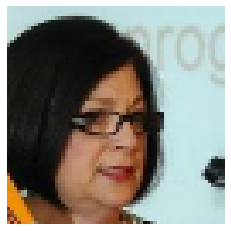

In [4]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### Discriminator

In [5]:
discriminator = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Conv2D(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator"
)

In [6]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### Generator

In [7]:
latent_dim = 128

generator = Sequential(
    [
        Input(shape=(latent_dim,)),
        Dense(8 * 8 * 128),
        Reshape((8, 8, 128)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator"
)

In [8]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

**The GAN `Model`**

In [9]:
class GAN(Model):

    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**A callback that samples generated images during training**

In [10]:
class GANMonitor(Callback):
    
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

**Compiling and training the GAN**

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=Adam(learning_rate=0.0001), 
    g_optimizer=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy()
)

gan.fit(dataset, epochs=20, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/20
6332/6332 [==============================] - 2670s 420ms/step - d_loss: 0.6083 - g_loss: 1.2051
Epoch 2/20
6332/6332 [==============================] - 2606s 412ms/step - d_loss: 0.6520 - g_loss: 1.0706
Epoch 3/20
6332/6332 [==============================] - 2618s 413ms/step - d_loss: 0.6679 - g_loss: 0.9945
Epoch 4/20
6332/6332 [==============================] - 2616s 413ms/step - d_loss: 0.6617 - g_loss: 1.0303
Epoch 5/20
6332/6332 [==============================] - 2632s 416ms/step - d_loss: 0.6461 - g_loss: 1.0828
Epoch 6/20
6332/6332 [==============================] - 2618s 413ms/step - d_loss: 0.6531 - g_loss: 1.0320
Epoch 7/20
6332/6332 [==============================] - 2618s 413ms/step - d_loss: 0.6640 - g_loss: 0.9415
Epoch 8/20
6332/6332 [==============================] - 2620s 414ms/step - d_loss: 0.6619 - g_loss: 0.9521
Epoch 9/20
6332/6332 [==============================] - 2657s 420ms/step - d_loss: 0.6612 - g_loss: 0.9542
Epoch 10/20
6332/6332 [==============